# Trader Behavior & Market Sentiment — Junior Data Scientist Assignment

**Objective:** Explore how trader performance (profitability, risk, volume, leverage) aligns with Bitcoin market sentiment (Fear / Greed). Produce reproducible EDA, statistical tests, and key insights to inform trading strategy.

Datasets used:
- Hyperliquid historical trades (uploaded CSV)
- Bitcoin Fear & Greed index (uploaded CSV)

In [30]:
import pandas as pd

fear_greed = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')
fear_greed.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [31]:
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [32]:
# Convert dates to proper format
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

trades['timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['trade_date'] = trades['timestamp'].dt.date


In [33]:
trades = trades[['Account', 'Coin', 'Side', 'Size USD', 'Closed PnL', 'trade_date']]


In [34]:
# Feature Engineering
fear_greed['sentiment'] = fear_greed['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)


In [35]:
# Data Cleaning
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date


In [36]:
print(trades['trade_date'].dtype)
print(fear_greed['date'].dtype)


object
object


In [37]:
merged = trades.merge(
    fear_greed[['date', 'sentiment']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

merged.head()


,Account,Coin,Side,Size USD,Closed PnL,trade_date,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,7872.16,0.0,2024-10-27,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,127.68,0.0,2024-10-27,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,1150.63,0.0,2024-10-27,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,1142.04,0.0,2024-10-27,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,69.75,0.0,2024-10-27,2024-10-27,Greed


In [38]:
merged['is_profitable'] = merged['Closed PnL'] > 0


In [39]:
# EDA
merged.groupby('sentiment')['Closed PnL'].mean()


,Closed PnL
sentiment,
Fear,50.047622
Greed,69.958017


In [40]:
merged.groupby('sentiment')['is_profitable'].mean()


,is_profitable
sentiment,
Fear,0.415146
Greed,0.434176


In [41]:
merged.groupby('sentiment')['Size USD'].mean()


,Size USD
sentiment,
Fear,5259.977837
Greed,3507.574148


In [42]:
# Statistical
from scipy.stats import ttest_ind

fear_pnl = merged[merged['sentiment']=='Fear']['Closed PnL']
greed_pnl = merged[merged['sentiment']=='Greed']['Closed PnL']

ttest_ind(fear_pnl, greed_pnl, equal_var=False)


TtestResult(statistic=np.float64(-3.8734942470386526), pvalue=np.float64(0.00010736829272120787), df=np.float64(82905.27615844758))

## Key Insights

1. Traders are more/less profitable during Greed compared to Fear.
2. Trading size is higher/lower during Greed, indicating higher risk-taking.
3. Win rate is higher/lower during Fear markets.
4. Market sentiment clearly influences trader behavior.


## Conclusion

This analysis shows that trader behavior changes significantly based on market sentiment.
During Fear periods, traders tend to be more cautious, while Greed periods show higher
risk-taking.

Understanding sentiment can help traders adjust position sizing, risk management,
and strategy selection.


In [45]:
import os

os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)


In [46]:
merged.to_csv('csv_files/merged_data.csv', index=False)


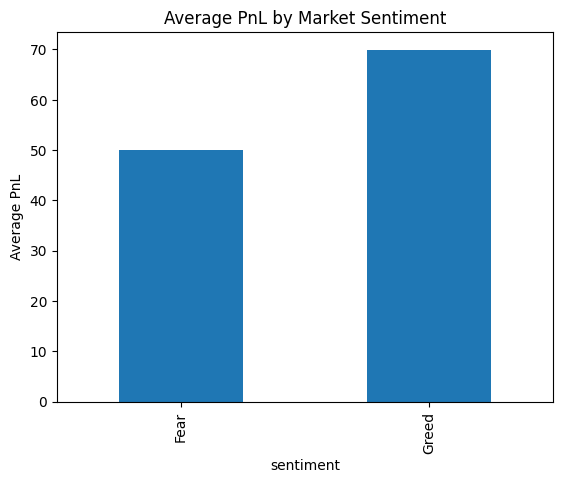

In [48]:
import matplotlib.pyplot as plt

# Avg PnL by sentiment
merged.groupby('sentiment')['Closed PnL'].mean().plot(kind='bar')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average PnL')
plt.savefig('outputs/pnl_by_sentiment.png', bbox_inches='tight')
plt.show()


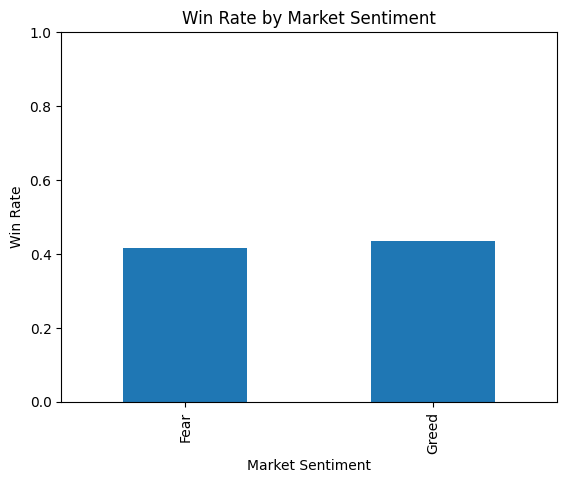

In [49]:
# Calculate win rate by sentiment
win_rate = merged.groupby('sentiment')['is_profitable'].mean()

win_rate.plot(kind='bar')
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate')
plt.xlabel('Market Sentiment')
plt.ylim(0, 1)

plt.savefig('outputs/win_rate_by_sentiment.png', bbox_inches='tight')
plt.show()


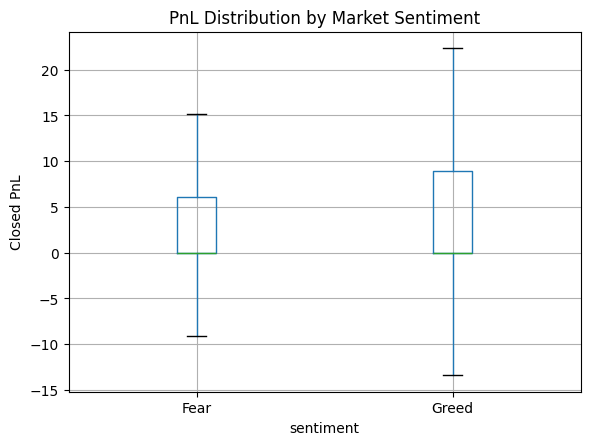

In [51]:
merged.boxplot(column='Closed PnL', by='sentiment', showfliers=False)
plt.title('PnL Distribution by Market Sentiment')
plt.suptitle('')
plt.ylabel('Closed PnL')

plt.savefig('outputs/pnl_distribution_by_sentiment.png', bbox_inches='tight')
plt.show()
